### Cross Validition

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneOut 
import os
import glob

species = 'mouse'
tissue = 'heart'

# File paths for benchmark essential/non-essential lncRNAs
esslnc_path = f'../../data/benchmark/{species}/ess_lnc.csv'
nonesslnc_path = f'../../data/benchmark/{species}/noness_lnc.csv'

# 1. Collect all embedding files to be evaluated
embedding_folder = f'./{species}/'
embedding_files = glob.glob(f'{embedding_folder}/*.csv')  # Adjust pattern as needed

# 2. Create output folders if not exist
exp_detail_dir = f'./{species}/experiment_details/'
curve_dir = f'./{species}/performance/curve/'
summary_path = f'./{species}/performance/svm_all_summary.csv'
os.makedirs(exp_detail_dir, exist_ok=True)
os.makedirs(curve_dir, exist_ok=True)
os.makedirs(f'./{species}/performance/', exist_ok=True)

# 3. Read ground-truth essential/non-essential lncRNA IDs
esslnc = pd.read_csv(esslnc_path)
nonesslnc = pd.read_csv(nonesslnc_path)
esslnc_id = set(esslnc['lncRNA_id'])
nonesslnc_id = set(nonesslnc['lncRNA_id'])

# 4. List to store summary metrics of all runs
metrics_all = []

# 5. Iterate through all embedding files
for embed_path in embedding_files:
    # --- Parse experiment tag from file name for output naming ---
    embed_file = os.path.basename(embed_path)
    embed_type = embed_file.replace(f'lncRNA_embeddings_{tissue}_', '').replace('.csv', '')  # Customize if needed

    # --- Load lncRNA embeddings and match with labels ---
    lnc = pd.read_csv(embed_path, index_col=0, header=None)
    lnc_ess = lnc[lnc.index.isin(esslnc_id)]
    lnc_noness = lnc[lnc.index.isin(nonesslnc_id)]
    X_positive = lnc_ess.values
    X_negative = lnc_noness.values
    ids_positive = lnc_ess.index
    ids_negative = lnc_noness.index
    X_all = np.vstack((X_positive, X_negative))
    y_all = np.hstack((np.ones(len(X_positive)), np.zeros(len(X_negative))))
    ids_all = np.hstack((ids_positive, ids_negative))

    # --- Setup cross-validation ---
    if species == 'mouse':
        cv = LeaveOneOut()
        C = 10
    else:
        cv = KFold(n_splits=10, shuffle=True, random_state=42)
        C = 100

    # --- DataFrame to record fold-level experiment details ---
    experiment_records = pd.DataFrame()
    all_true_labels = []
    all_decision_scores = []

    # --- Main cross-validation loop ---
    for fold, (train_index, test_index) in enumerate(cv.split(X_all)):
        X_train, X_test = X_all[train_index], X_all[test_index]
        y_train, y_test = y_all[train_index], y_all[test_index]
        ids_train, ids_test = ids_all[train_index], ids_all[test_index]

        # Scale features using MinMaxScaler
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train SVM
        svm = LinearSVC(C=C, dual=False)
        svm.fit(X_train_scaled, y_train)
        decision_scores = svm.decision_function(X_test_scaled)
        predictions = (decision_scores >= 0).astype(int)

        # Record details for this fold
        fold_data = {
            'Fold': fold + 1,
            'Train_IDs': [list(ids_train)],
            'Train_Labels': [list(y_train)],
            'Test_IDs': [list(ids_test)],
            'Test_Labels': [list(y_test)],
            'Predictions': [list(predictions)],
            'Decision_Scores': [list(decision_scores)]
        }
        fold_df = pd.DataFrame(fold_data)
        experiment_records = pd.concat([experiment_records, fold_df], ignore_index=True)
        all_true_labels.extend(y_test)
        all_decision_scores.extend(decision_scores)

    # --- Calculate overall performance for the current embedding ---
    all_true_labels = np.array(all_true_labels)
    all_decision_scores = np.array(all_decision_scores)
    tn, fp, fn, tp = confusion_matrix(all_true_labels, (all_decision_scores >= 0).astype(int)).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1_score = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0
    mcc = matthews_corrcoef(all_true_labels, (all_decision_scores >= 0).astype(int))

    # --- Save experiment details for this embedding file ---
    exp_detail_path = os.path.join(exp_detail_dir, f'svm_{embed_type}_experiment_details.csv')
    experiment_records.to_csv(exp_detail_path, index=False)

    # --- Compute and save ROC/PR curve data ---
    fpr, tpr, _ = roc_curve(all_true_labels, all_decision_scores)
    roc_auc = auc(fpr, tpr)
    roc_curve_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
    roc_curve_df.to_csv(os.path.join(curve_dir, f'roc_curve_{embed_type}.csv'), index=False)

    precision, recall, _ = precision_recall_curve(all_true_labels, all_decision_scores)
    pr_auc = auc(recall, precision)
    pr_curve_df = pd.DataFrame({'Recall': recall, 'Precision': precision})
    pr_curve_df.to_csv(os.path.join(curve_dir, f'pr_curve_{embed_type}.csv'), index=False)

    # --- Collect summary metrics in memory for final table ---
    metrics_row = {
        'Model': 'SVM',
        'Embed_Type': embed_type,
        'Sensitivity(Recall)': round(sensitivity,4),
        'Specificity': round(specificity,4),
        'PPV(Precision)': round(ppv,4),
        'F1_Score': round(f1_score,4),
        'Accuracy': round(accuracy,4),
        'MCC': round(mcc,4),
        'ROC_AUC': round(roc_auc,4),
        'PR_AUC': round(pr_auc,4)
    }
    metrics_all.append(metrics_row)

# --- Save the summary table (all embeddings) at the end ---
metrics_df = pd.DataFrame(metrics_all)
metrics_df.to_csv(summary_path, index=False)

print("All experiments finished! All experiment details, ROC/PR curves, and summary metrics saved.")


All experiments finished! All experiment details, ROC/PR curves, and summary metrics saved.


### Draw the comprehensive performance curve

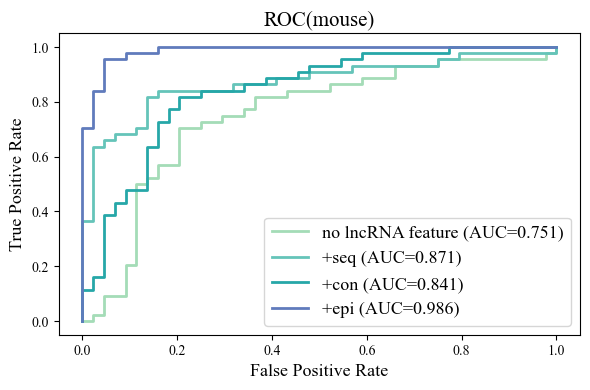

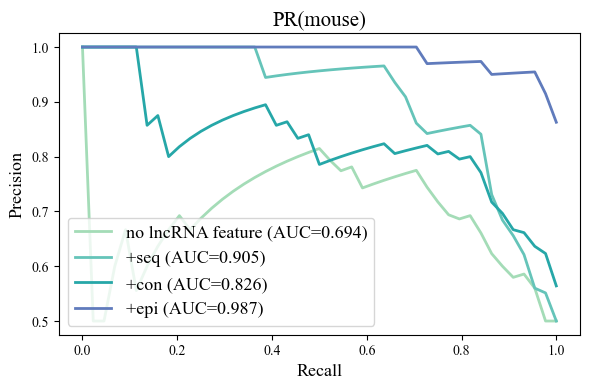

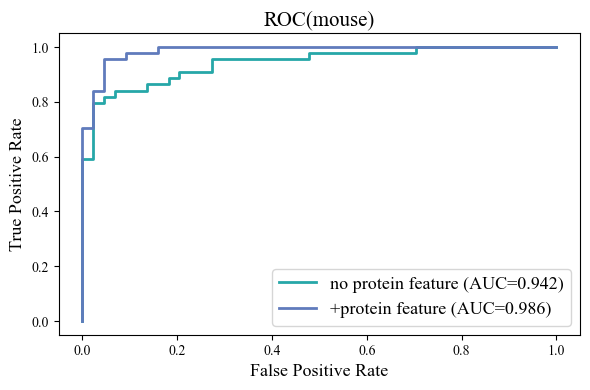

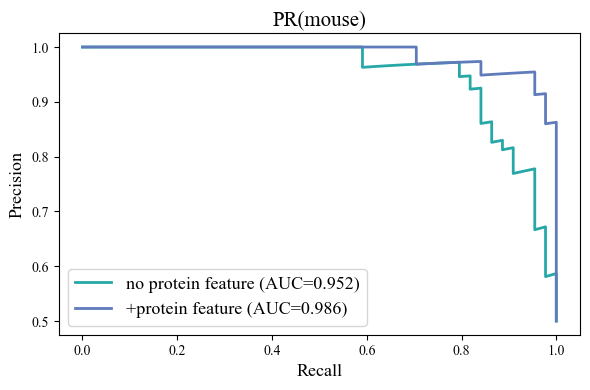

In [10]:
from matplotlib import rcParams
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import auc as sk_auc

rcParams['font.family'] = 'Times New Roman'

species = 'mouse'
curve_dir = f'./{species}/performance/curve/'

# Define your desired plot order and colors
lnc_plot_config = {
    'no lncRNA feature': '#a4dcb7',
    '+seq': '#65c4b9',
    '+con': '#26a7a8',
    '+epi': '#607bbc',
}

prot_plot_config = {
    'no protein feature': '#26a7a8',
    '+protein feature': '#607bbc'
}

def load_and_process_pr(pr_path):
    pr_df = pd.read_csv(pr_path)

    # 1) Sort by recall (important for stable plotting and AUC calculation)
    pr_df = pr_df.sort_values("Recall")

    # 2) If there are duplicated recall values, keep the best precision (upper envelope)
    pr_df = pr_df.groupby("Recall", as_index=False)["Precision"].max()

    # 3) Ensure recall is increasing (required by sk_auc)
    #    After sorting+groupby, this should already be increasing
    return pr_df


# lncRNA side
# === Plot ROC curves ===
plt.figure(figsize=(6, 4))
for label, color in lnc_plot_config.items():
    roc_path = os.path.join(curve_dir, f'roc_curve_{label}.csv')
    roc_df = pd.read_csv(roc_path)     
    auc = sk_auc(roc_df['FPR'], roc_df['TPR'])
    plt.plot(roc_df['FPR'], roc_df['TPR'], lw=2, label=f"{label} (AUC={auc:.3f})", color=color)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title(f'ROC({species})', fontsize=15)
plt.legend(loc='lower right', fontsize=13)
plt.tight_layout()
plt.savefig(f'./{species}/performance/roc_curve_{species}_ablation_lnc.svg')
plt.show()


# === Plot PR curves ===
#plt.figure(figsize=(6, 4))
#for label, color in lnc_plot_config.items():
#    pr_path = os.path.join(curve_dir, f'pr_curve_{label}.csv')
#    pr_df = pd.read_csv(pr_path)
#    auprc = sk_auc(pr_df['Recall'], pr_df['Precision'])
#    plt.plot(pr_df['Recall'], pr_df['Precision'], lw=2, label=f"{label} (AUC={auprc:.3f})", color=color)
#plt.xlim(0.1, 1.05)
#plt.ylim(0.05, 1.05)
#plt.xlabel('Recall', fontsize=13)
#plt.ylabel('Precision', fontsize=13)
#plt.title(f'PR({species})', fontsize=15)
#plt.legend(loc='lower left', fontsize=13)
#plt.tight_layout()
#plt.savefig(f'./{species}/performance/pr_curve_{species}_ablation_lnc.svg')
#plt.show()

plt.figure(figsize=(6, 4))
for label, color in lnc_plot_config.items():
    pr_path = os.path.join(curve_dir, f'pr_curve_{label}.csv')

    pr_df = load_and_process_pr(pr_path)
    auprc = sk_auc(pr_df['Recall'], pr_df['Precision'])

    plt.plot(pr_df['Recall'], pr_df['Precision'], lw=2,
             label=f"{label} (AUC={auprc:.3f})", color=color)

#plt.xlim(0.1, 1.05)
#plt.ylim(0.05, 1.05)
plt.xlabel('Recall', fontsize=13)
plt.ylabel('Precision', fontsize=13)
plt.title(f'PR({species})', fontsize=15)
plt.legend(loc='lower left', fontsize=13)
plt.tight_layout()
plt.savefig(f'./{species}/performance/pr_curve_{species}_ablation_lnc.svg')
plt.show()


# protein side
# === Plot ROC curves ===
plt.figure(figsize=(6, 4))
for label, color in prot_plot_config.items():
    roc_path = os.path.join(curve_dir, f'roc_curve_{label}.csv')
    roc_df = pd.read_csv(roc_path)     
    auc = sk_auc(roc_df['FPR'], roc_df['TPR'])
    plt.plot(roc_df['FPR'], roc_df['TPR'], lw=2, label=f"{label} (AUC={auc:.3f})", color=color)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title(f'ROC({species})', fontsize=15)
plt.legend(loc='lower right', fontsize=13)
plt.tight_layout()
plt.savefig(f'./{species}/performance/roc_curve_{species}_ablation_prot.svg')
plt.show()


# === Plot PR curves ===
plt.figure(figsize=(6, 4))
for label, color in prot_plot_config.items():
    pr_path = os.path.join(curve_dir, f'pr_curve_{label}.csv')
    pr_df = pd.read_csv(pr_path)
    auprc = sk_auc(pr_df['Recall'], pr_df['Precision'])
    plt.plot(pr_df['Recall'], pr_df['Precision'], lw=2, label=f"{label} (AUC={auprc:.3f})", color=color)
plt.xlabel('Recall', fontsize=13)
plt.ylabel('Precision', fontsize=13)
plt.title(f'PR({species})', fontsize=15)
plt.legend(loc='lower left', fontsize=13)
plt.tight_layout()
plt.savefig(f'./{species}/performance/pr_curve_{species}_ablation_prot.svg')
plt.show()
